In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# import os
# os.getcwd()

In [3]:
net_A = np.genfromtxt('data/skin_net_A.csv', delimiter="\t")
net_A.shape

(3000, 3000)

In [4]:
net_B = np.genfromtxt('data/skin_net_B.csv', delimiter="\t")
net_B.shape

(3000, 3000)

In [5]:
TFs = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Xct/dev2/DB/41587_2020_742_MOESM3_ESM.csv', header=None, names=['TF_symbol'])
len(TFs)

1564

In [6]:
ada = sc.read_h5ad("data/LS_processed.h5ad")
gene_names = np.array(ada.var_names)

ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

In [7]:
def net_to_df(net, gene_names):
    if not (net == net.T).all():
        raise ValueError('require a symmetric array')
    else:
        #net[abs(net) < np.percentile(abs(net), 100-keep)] = 0 #global trim edges
        net = pd.DataFrame(net, columns=gene_names, index=gene_names)
    return net     

In [8]:
visual_style = {}
visual_style["vertex_size"] = 32
visual_style["vertex_label_size"] = 11
visual_style["vertex_label_dist"] = 0.0

visual_style["edge_curved"] = 0.1
# visual_style["edge_arrow_size"] = 1
# visual_style["edge_arrow_width"] = 0.3


visual_style["bbox"] = (500, 500)
visual_style["margin"] = 30

arguments for plot(): <br>
https://igraph.org/python/doc/api/igraph.Graph.html#:~:text=def%20__plot__(self%2C%20context%2C%20bbox%2C%20palette%2C%20*args%2C%20**kwds)%3A

In [9]:
import random
import warnings

def vis_net(net, TF_DB, target, top_edges = 20, show = True, saveas = None, verbose = False, visual_style = visual_style):
    if not isinstance(net, pd.DataFrame):
        raise TypeError('convert GRN to dataframe with gene names first')
    else:
        g_to_use = TF_DB['TF_symbol'].tolist()
        g_to_use_orig = g_to_use.copy()
        g_to_use = g_to_use + target
      
        net_f = net.loc[net.index.isin(g_to_use), net.columns.isin(g_to_use)].copy() #subset net by TFs and LRs
        net_f.loc[net_f.index.isin(g_to_use_orig), net_f.columns.isin(g_to_use_orig)] = 0 # set !LR row and col = 0, not interested
        net_f.astype('float64')
        if verbose:
            print(f'identified {len(net_f)} TF(s) along with {len(target)} ligand/receptor target(s)')
        
        idx_target = [list(net_f.index).index(g) for g in target]
        is_TF = np.ones(len(net_f), dtype=bool)
        for idx in idx_target:
            is_TF[idx] = False 
                
        mat = net_f.values.copy()
        gene_names_f = net_f.index.tolist()
        
        g = ig.Graph.Weighted_Adjacency(mat, mode='undirected', attr="weight", loops=True)
        g.vs["name"] = gene_names_f
        g.vs["is_TF"] = is_TF
        
        #trim low weight edges
        #cut = np.percentile(np.abs(g.es['weight']), 100-keep)
        #edges_delete_ids = [e.index for e in g.es if abs(e['weight']) < cut]
        abs_weight = [abs(w) for w in g.es['weight']]
        edges_delete_ids = sorted(range(len(abs_weight)), key=lambda k: abs_weight[k])[:-top_edges*len(target)] #idx from bottom
        g.delete_edges(edges_delete_ids)
        #print(len(g.es['weight']))

        #delete isolated nodes
        to_delete_ids = []
        for v in g.vs: 
            if v.degree() == 0:
                to_delete_ids.append(v.index) 
                if v['name'] in target:
                    warnings.warn(f"{v['name']} has been removed due to degree zero")
        g.delete_vertices(to_delete_ids)

        if verbose:   
            print(f'undirected graph constructed: \n# of nodes: {len(g.vs)}, # of edges: {len(g.es)}')
         
        #graph-specific visual_style after graph building
        visual_style["vertex_label"] = g.vs["name"]
        visual_style["vertex_color"] = ['darkgray' if tf==1 else 'darkorange' for tf in g.vs["is_TF"]]
        scale = 3/max(np.abs(g.es['weight']))
        visual_style["edge_width"] = [scale*abs(w) for w in g.es['weight']] 
        visual_style["edge_color"] = ['red' if w>0 else 'blue' for w in g.es['weight']]
        visual_style["layout"] = 'large'
        
        random.seed(1) #layout
        if show:
            if saveas is None:
                return ig.plot(g, **visual_style)
            else:
                if verbose:
                    print(f'graph saved as \"{saveas}.png\"')
                return ig.plot(g, f'{saveas}.png', **visual_style)
        else:
            return g          
    

In [10]:
net_A_g = net_to_df(net_A, gene_names)
net_A_g.shape

(3000, 3000)

identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 32, # of edges: 40
graph saved as "test_A.png"


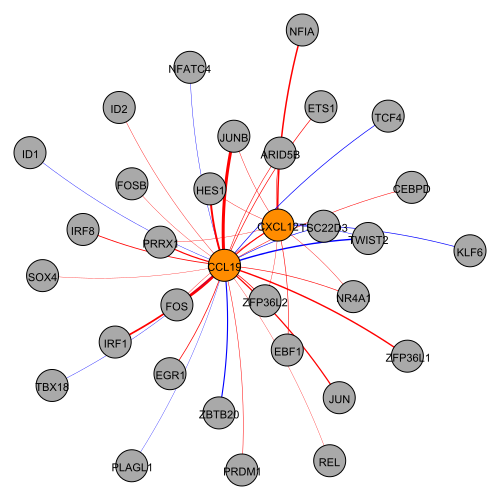

In [11]:
vis_net(net_A_g, TFs, target=['CCL19', 'CXCL12'], top_edges=20, show = True, verbose = True, saveas = 'test_A')

In [12]:
net_B_g = net_to_df(net_B, gene_names)
net_B_g.shape

(3000, 3000)

identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 39, # of edges: 50
graph saved as "test_B.png"


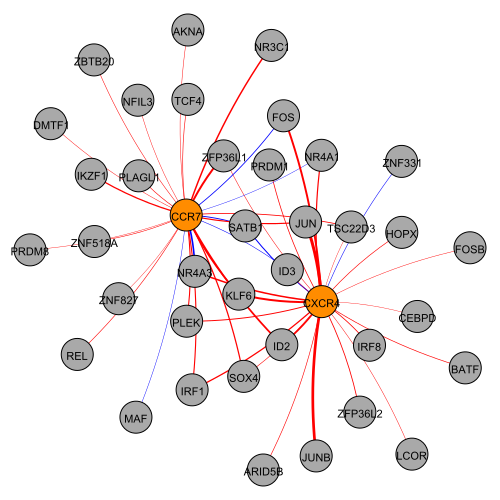

In [13]:
vis_net(net_B_g, TFs, target=['CCR7', 'CXCR4'], top_edges=25, show = True, verbose = True, saveas = 'test_B')

### merge graphs:

In [14]:
g_A = vis_net(net_A_g, TFs, target=['CCL19', 'CXCL12'], top_edges=25, show = False, verbose = True)
g_B = vis_net(net_B_g, TFs, target=['CCR7', 'CXCR4'], top_edges=25, show = False, verbose = True)

identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 37, # of edges: 50
identified 217 TF(s) along with 2 ligand/receptor target(s)
undirected graph constructed: 
# of nodes: 39, # of edges: 50


In [15]:
g_A.vs[0], g_B.vs[-1]

(igraph.Vertex(<igraph.Graph object at 0x00000282529067C0>, 0, {'name': 'ZFP36L1', 'is_TF': True}),
 igraph.Vertex(<igraph.Graph object at 0x0000028252906D60>, 38, {'name': 'FOS', 'is_TF': True}))

In [16]:
g_A.es[0], g_B.es[-1]

(igraph.Edge(<igraph.Graph object at 0x00000282529067C0>, 0, {'weight': 0.05418941654243635}),
 igraph.Edge(<igraph.Graph object at 0x0000028252906D60>, 49, {'weight': 0.1165730159176892}))

In [17]:
g_comb = g_A.disjoint_union(g_B) #merge disjointly

len(g_comb.vs), len(g_comb.es)

(76, 100)

https://igraph.org/python/doc/api/igraph.operators.html#disjoint_union

In [18]:
g_comb.vs[0], g_comb.vs[-1]

(igraph.Vertex(<igraph.Graph object at 0x0000028257A62310>, 0, {'name': 'ZFP36L1', 'is_TF': True}),
 igraph.Vertex(<igraph.Graph object at 0x0000028257A62310>, 75, {'name': 'FOS', 'is_TF': True}))

In [19]:
g_comb.es[0], g_comb.es[-1]

(igraph.Edge(<igraph.Graph object at 0x0000028257A62310>, 0, {'weight': 0.05418941654243635}),
 igraph.Edge(<igraph.Graph object at 0x0000028257A62310>, 99, {'weight': 0.1165730159176892}))

In [20]:
g_comb_orig = g_comb.copy()

In [21]:
#g_comb = g_comb_orig.copy()

In [22]:
def vis_net_merge(g, target = None, saveas = None, verbose = False):

    for pair in target:
        edges_idx = (g.vs.find(name = pair[0]).index, g.vs.find(name = pair[1]).index) #from to
        g.add_edge(edges_idx[0], edges_idx[1], weight = 1.1)
        if verbose:
            print(f'edge from {pair[0]} to {pair[1]} added')

    visual_style["vertex_label"] = g.vs["name"]
    visual_style["vertex_color"] = ['darkgray' if tf==1 else 'darkorange' for tf in g.vs["is_TF"]]
    scale = 3/max(np.abs(g.es['weight']))
    visual_style["edge_width"] = [scale*abs(w) for w in g.es['weight']] 
    visual_style["edge_color"] = ['red' if (w>0)&(w<=1) else ('maroon' if w>1 else 'blue') for w in g.es['weight']]
    visual_style["layout"] = 'kk'
    
    
    random.seed(42) #layout
    if saveas is None:
        return ig.plot(g, **visual_style)
    else:
        if verbose:
            print(f'graph saved as \"{saveas}.png\"')
        return ig.plot(g, f'{saveas}.png', **visual_style)


edge from CCL19 to CCR7 added
edge from CXCL12 to CXCR4 added


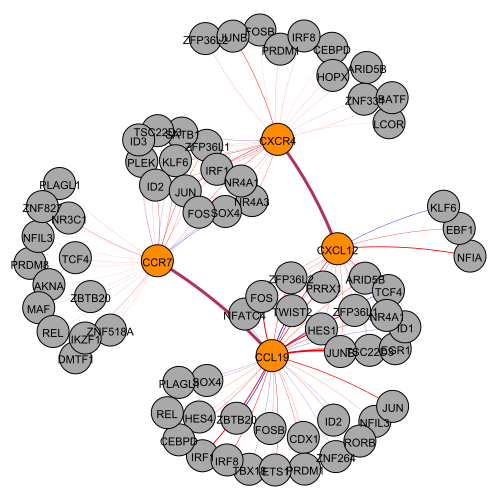

In [23]:
vis_net_merge(g_comb, [('CCL19', 'CCR7'), ('CXCL12', 'CXCR4')], verbose = True)

https://igraph.org/python/doc/tutorial/tutorial.html#vertex-attributes-controlling-graph-plots